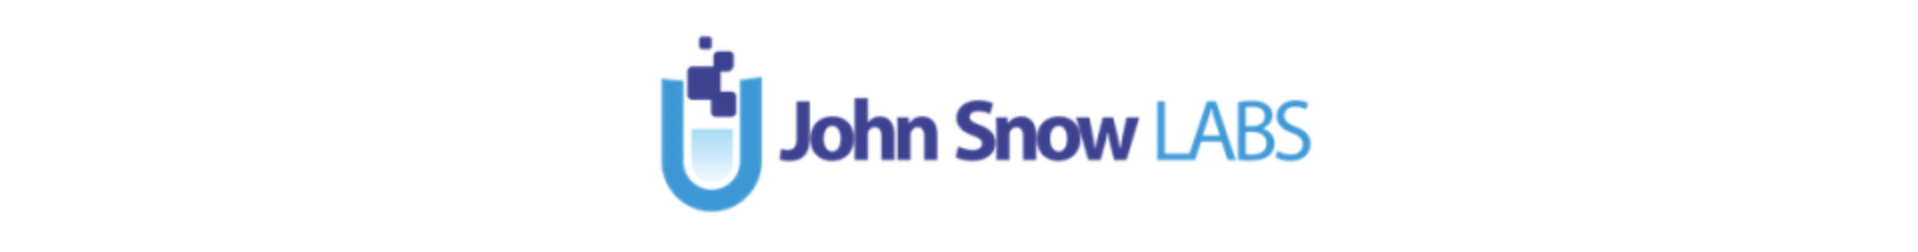



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/tutorials/Certification_Trainings/Public/5.Text_Classification_with_ClassifierDL.ipynb)

# Text Classification with ClassifierDL

## 0. Colab Setup

In [0]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed -q spark-nlp==2.4.5

openjdk version "1.8.0_242"
OpenJDK Runtime Environment (build 1.8.0_242-8u242-b08-0ubuntu3~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.242-b08, mixed mode)
     |████████████████████████████████| 215.7MB 66kB/s 
     |████████████████████████████████| 204kB 42.4MB/s 
     |████████████████████████████████| 112kB 2.8MB/s 


In [0]:
import sparknlp

spark = sparknlp.start() # for GPU training >> sparknlp.start(gpu=True)

from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark

Spark NLP version 2.4.5
Apache Spark version: 2.4.4


## Load Dataset

In [0]:
!wget -O news_category_train.csv https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category/news_category_train.csv


!wget -O news_category_test.csv https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category/news_category_test.csv

--2020-04-07 16:42:04--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category/news_category_train.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.9.181
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.9.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24032125 (23M) [text/csv]
Saving to: ‘news_category_train.csv’

news_category_train 100%[===================>]  22.92M  83.3MB/s    in 0.3s    

2020-04-07 16:42:05 (83.3 MB/s) - ‘news_category_train.csv’ saved [24032125/24032125]

--2020-04-07 16:42:06--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category/news_category_test.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.93.253
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.93.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1504408 (1.4M) [text/csv]
Saving to: ‘news_category_test.csv’

news_categor

In [0]:
!ls -lt

total 24948
drwxr-xr-x 1 root root     4096 Apr  3 16:24 sample_data
-rw-r--r-- 1 root root  1504408 Mar 16 10:34 news_category_test.csv
-rw-r--r-- 1 root root 24032125 Mar 16 10:33 news_category_train.csv


In [0]:
trainDataset = spark.read \
      .option("header", True) \
      .csv("news_category_train.csv")

trainDataset.show(truncate=50)

+--------+--------------------------------------------------+
|category|                                       description|
+--------+--------------------------------------------------+
|Business| Short sellers, Wall Street's dwindling band of...|
|Business| Private investment firm Carlyle Group, which h...|
|Business| Soaring crude prices plus worries about the ec...|
|Business| Authorities have halted oil export flows from ...|
|Business| Tearaway world oil prices, toppling records an...|
|Business| Stocks ended slightly higher on Friday but sta...|
|Business| Assets of the nation's retail money market mut...|
|Business| Retail sales bounced back a bit in July, and n...|
|Business|" After earning a PH.D. in Sociology, Danny Baz...|
|Business| Short sellers, Wall Street's dwindling  band o...|
|Business| Soaring crude prices plus worries  about the e...|
|Business| OPEC can do nothing to douse scorching  oil pr...|
|Business| Non OPEC oil exporters should consider  increa...|
|Busines

In [0]:
trainDataset.count()


120000

In [0]:
from pyspark.sql.functions import col

trainDataset.groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|category|count|
+--------+-----+
|   World|30000|
|Sci/Tech|30000|
|  Sports|30000|
|Business|30000|
+--------+-----+



In [0]:
testDataset = spark.read \
      .option("header", True) \
      .csv("news_category_test.csv")


testDataset.groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|category|count|
+--------+-----+
|Sci/Tech| 1900|
|  Sports| 1900|
|   World| 1900|
|Business| 1900|
+--------+-----+



In [0]:
# if we want to split the dataset
'''
(trainingData, testData) = trainDataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
'''

## ClassiferDL with Word Embeddings and Text Preprocessing

In [0]:
# actual content is inside description column
document_assembler = DocumentAssembler() \
    .setInputCol("description") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
  .setInputCols(["document"]) \
  .setOutputCol("token")
    
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")

glove_embeddings = WordEmbeddingsModel().pretrained() \
 .setInputCols(["document",'lemma'])\
 .setOutputCol("embeddings")\
 .setCaseSensitive(False)

embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["document", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("category")\
  .setMaxEpochs(3)\
  .setEnableOutputLogs(True)

clf_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            lemma, 
            glove_embeddings,
            embeddingsSentence,
            classsifierdl])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [0]:
# Train (8 min for 10 epochs)
%%time

clf_pipelineModel = clf_pipeline.fit(trainDataset)

CPU times: user 158 ms, sys: 29.5 ms, total: 188 ms
Wall time: 8min 22s


In [0]:
!cd ~/annotator_logs && ls -l


total 4
-rw-r--r-- 1 root root 976 Apr  7 16:59 ClassifierDLApproach_f222663dfb2c.log


In [0]:
!cat ~/annotator_logs/ClassifierDLApproach_f222663dfb2c.log


Training started - total epochs: 10 - learning rate: 0.005 - batch size: 64 - training examples: 120000
Epoch 0/10 - 35.42044908%.2fs - loss: 1637.3722 - accuracy: 0.8689917 - batches: 1875
Epoch 1/10 - 36.031757286%.2fs - loss: 1609.2766 - accuracy: 0.88155836 - batches: 1875
Epoch 2/10 - 34.908468392%.2fs - loss: 1603.4879 - accuracy: 0.886125 - batches: 1875
Epoch 3/10 - 34.849212057%.2fs - loss: 1596.2185 - accuracy: 0.889725 - batches: 1875
Epoch 4/10 - 34.979911249%.2fs - loss: 1592.2081 - accuracy: 0.89270836 - batches: 1875
Epoch 5/10 - 35.059568873%.2fs - loss: 1588.2047 - accuracy: 0.89515835 - batches: 1875
Epoch 6/10 - 34.855471653%.2fs - loss: 1583.6277 - accuracy: 0.8974583 - batches: 1875
Epoch 7/10 - 34.498874087%.2fs - loss: 1579.1383 - accuracy: 0.89934164 - batches: 1875
Epoch 8/10 - 35.507189799%.2fs - loss: 1575.4302 - accuracy: 0.90068334 - batches: 1875
Epoch 9/10 - 34.665519006%.2fs - loss: 1572.7279 - accuracy: 0.9023167 - batches: 1875


In [0]:
# get the predictions on test Set

preds = clf_pipelineModel.transform(testDataset)


In [0]:
preds.select('category','description',"class.result").show(10, truncate=80)


+--------+--------------------------------------------------------------------------------+----------+
|category|                                                                     description|    result|
+--------+--------------------------------------------------------------------------------+----------+
|Business|Unions representing workers at Turner   Newall say they are 'disappointed' af...|[Business]|
|Sci/Tech| TORONTO, Canada    A second team of rocketeers competing for the  #36;10 mil...|[Sci/Tech]|
|Sci/Tech| A company founded by a chemistry researcher at the University of Louisville ...|[Sci/Tech]|
|Sci/Tech| It's barely dawn when Mike Fitzpatrick starts his shift with a blur of color...|  [Sports]|
|Sci/Tech| Southern California's smog fighting agency went after emissions of the bovin...|   [World]|
|Sci/Tech|"The British Department for Education and Skills (DfES) recently launched a "...|[Sci/Tech]|
|Sci/Tech|"confessed author of the Netsky and Sasser viruses, is responsi

In [0]:
preds_df = preds.select('category','description',"class.result").toPandas()

# The result is an array since in Spark NLP you can have multiple sentences.
# Let's explode the array and get the item(s) inside of result column out
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])


In [0]:
# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report

print (classification_report(preds_df['result'], preds_df['category']))


              precision    recall  f1-score   support

    Business       0.84      0.84      0.84      1908
    Sci/Tech       0.86      0.86      0.86      1914
      Sports       0.97      0.95      0.96      1938
       World       0.88      0.91      0.89      1840

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



## ClassifierDL with Universal Sentence Embeddings

In [0]:
# actual content is inside description column
document = DocumentAssembler()\
    .setInputCol("description")\
    .setOutputCol("document")
    
# we can also use sentece detector here if we want to train on and get predictions for each sentence

use = UniversalSentenceEncoder.pretrained()\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("category")\
  .setMaxEpochs(5)\
  .setEnableOutputLogs(True)

use_clf_pipeline = Pipeline(
    stages = [
        document,
        use,
        classsifierdl
    ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [0]:
use_pipelineModel = use_clf_pipeline.fit(trainDataset)
# 5 epochs takes around 10 min


In [0]:
!cd ~/annotator_logs && ls -l


total 8
-rw-r--r-- 1 root root 533 Apr  7 17:14 ClassifierDLApproach_a0fddc9e970b.log
-rw-r--r-- 1 root root 976 Apr  7 16:59 ClassifierDLApproach_f222663dfb2c.log


In [0]:
!cat ~/annotator_logs/ClassifierDLApproach_a0fddc9e970b.log


Training started - total epochs: 5 - learning rate: 0.005 - batch size: 64 - training examples: 120000
Epoch 0/5 - 34.868680102%.2fs - loss: 1620.7466 - accuracy: 0.8803833 - batches: 1875
Epoch 1/5 - 35.627811455%.2fs - loss: 1604.4518 - accuracy: 0.8915333 - batches: 1875
Epoch 2/5 - 34.687788982%.2fs - loss: 1597.8773 - accuracy: 0.8966333 - batches: 1875
Epoch 3/5 - 34.629944711%.2fs - loss: 1593.4987 - accuracy: 0.900275 - batches: 1875
Epoch 4/5 - 34.714090256%.2fs - loss: 1590.3165 - accuracy: 0.90335834 - batches: 1875


## Getting prediction from Trained model

In [0]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(use_pipelineModel)

In [0]:
testDataset.select('description').take(2)

[Row(description="Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."),
 Row(description=' TORONTO, Canada    A second team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for privately funded suborbital space flight, has officially announced the first launch date for its manned rocket.')]

In [0]:
text='''
Fearing the fate of Italy, the centre-right government has threatened to be merciless with those who flout tough restrictions. 
As of Wednesday it will also include all shops being closed across Greece, with the exception of supermarkets. Banks, pharmacies, pet-stores, mobile phone stores, opticians, bakers, mini-markets, couriers and food delivery outlets are among the few that will also be allowed to remain open.
'''
result = light_model.annotate(text)

result['class']

['Business']

### Saving the trained model

In [0]:
use_pipelineModel.stages

[DocumentAssembler_931cb56f8fd1,
 UNIVERSAL_SENTENCE_ENCODER_29d4e3f03bbf,
 ClassifierDLModel_aba5bb481cbc]

In [0]:
use_pipelineModel.stages[2].write().overwrite().save('ClassifierDL_USE_20200407_e5')

In [0]:
classsifierdlmodel = ClassifierDLModel.load('ClassifierDL_USE_20200407_e5')
